In this file I'll do the analysis of the data I collected on Orfeo regarding the MPI barrier collective operation: in particular, the focus of the analysis will be on the average latency of the operation.

In [7]:
# Import the necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm

In [8]:
# Import the data collected on Orfeo
barrier_default = pd.read_csv("./Results/barrier_default.csv")
barrier_linear = pd.read_csv("./Results/barrier_linear.csv")
barrier_tree = pd.read_csv("./Results/barrier_tree.csv")
barrier_bruck = pd.read_csv("./Results/barrier_bruck.csv")

# Bind the data together in a single dataframe
barrier_results = pd.concat([barrier_default, barrier_linear, barrier_tree, barrier_bruck])

# Convert the Processes and Latency columns to int
barrier_results["Processes"] = barrier_results["Processes"].astype(int)
barrier_results["Latency"] = barrier_results["Latency"].astype(float)

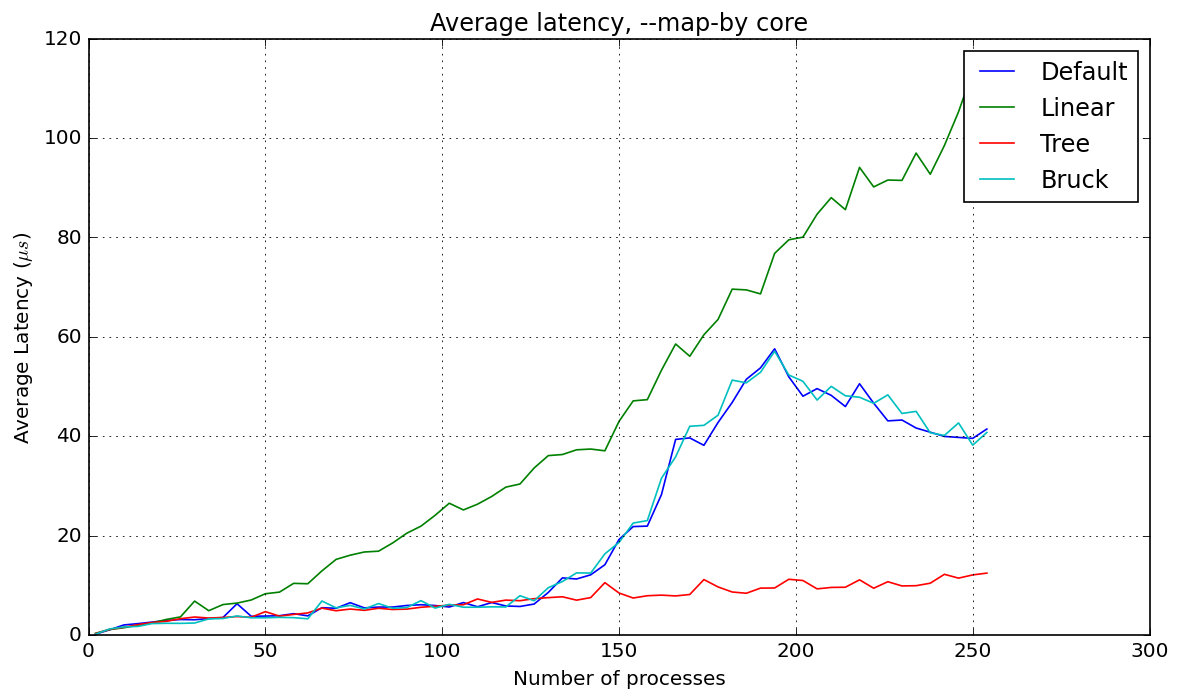

In [14]:
# Note: since we are now working with the barrier operation, we no longer have to deal with the size of the messages
# Let's now fix the map allocation to --map-by core (in fact, I obtained more consistent results and lower latencies) and 
# plot the results to compare the different algorithms' performances in terms of average latency

# Function to plot the algorithms' average latency for different map allocations against the number of processes
def algorithm_comparison(plot, i, map):
    
    # Filter the data for the given map allocation
    current_barrier = barrier_results[(barrier_results["Mapping"] == map) & (barrier_results["Processes"] != 256)]
    
    # Check if the map allocation is valid
    if current_barrier.empty:
        print("Invalid map allocation")
        return
    
    # Select the columns to plot
    x = current_barrier["Processes"].unique()
    y_default = current_barrier[current_barrier["Algorithm"] == "Default"]["Latency"]
    y_linear = current_barrier[current_barrier["Algorithm"] == "Linear"]["Latency"]
    y_tree = current_barrier[current_barrier["Algorithm"] == "Tree"]["Latency"]
    y_bruck = current_barrier[current_barrier["Algorithm"] == "Bruck"]["Latency"]
    
    # Create a 2D plot
    ax = plot.add_subplot(1, 1, i+1)
    
    # Plot the data and set the labels
    ax.plot(x, y_default, label="Default")
    ax.plot(x, y_linear, label="Linear")
    ax.plot(x, y_tree, label="Tree")
    ax.plot(x, y_bruck, label="Bruck")
    ax.set_xlabel("Number of processes")
    ax.set_ylabel("Average Latency ($\mu s$)")
    ax.set_title(f"Average latency, --map-by {map}")
    ax.legend()
    plt.grid(True)
    
# Create a single figure to plot the results
plt.style.use('classic')
plot = plt.figure(figsize=(10, 6), dpi=120, facecolor='w', edgecolor='k')

# Plot the results 
algorithm_comparison(plot, 0, "core")

# Fix the layout and show the plot
plt.tight_layout()
plt.show()
    